# set up the env
all import and settings useful for the project

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import mpmath as mp

In [22]:
# set mpmath precision: number of decimal digits
mp.mp.dps = 100

# utils
all functions used in coloring section

In [55]:
def draw_graph(G, X, C, pos):
    """Draw the graph with the colors

    Args:
        G (nx.Graph): Graph to draw
        X (list): List of colors for each node
        C (dict): Dictionary of colors
        pos (dict, list): Dictionary or list of positions
    """
    nx.draw(G, pos=pos, node_color=[C[x] for x in X], node_size=80, edgecolors='black')
    plt.show()

def NBR_dynamics(W, X, colors, iterations, noise, cost):
    """NBR dynamics: the core of the algorithm.
    For each time step, a node is chosen at random and a color is chosen, according to the probability distribution.
    The probability distribution is calculated using the cost function and the noise function.

    Args:
        W (np.array): Weight matrix (adjacency matrix)
        X (np.array): initial colors for each node
        colors (list): list of possible colors
        iterations (int): number of discrete time steps to run the algorithm for
        noise (function): noise function (float) -> float: takes the time step as input, returns a noise value
        cost (function): cost function (float, np.array) -> np.array: takes a scalar and a vector of node states as input, returns a cost vector

    Returns:
        list: list of node states for each discrete time step
    """
    # initialize the X
    X = X.copy()
    # save the X for each time step
    Xs = [X.copy()]
    # chosen nodes at each time step
    random_numbers = np.random.random(iterations-1)*(len(X)-1)
    chosen_nodes = np.int32(np.round(random_numbers))
    # function to calculate prob for each color
    prob = lambda c : mp.exp(-noise(t)*np.sum(W[n]*cost(c,X)))

    for t,n in tqdm(enumerate(chosen_nodes)):
        # calculate the probability for each color, add 1 to avoid 0 probabilities
        raw_probs = np.array([prob(c) for c in colors])
        # normalize the probabilities
        probs = raw_probs/np.sum(raw_probs)
        probs = probs.astype(np.float64)
        # choose the color following such distribution
        X[n] = np.random.choice(colors, p=probs)
        # save the X for each time step
        Xs.append(X.copy())
    return Xs

def NBR_potential(X, W, cost):
    """Calculate the potential of the graph at every time step

    Args:
        X (np.array): vector of node states for each discrete time step
        W (np.array): Weight matrix (adjacency matrix)
        cost (function): cost function (float, np.array) -> np.array: takes a scalar and a vector of node states as input, returns a cost vector

    Returns:
        list: list of potentials for each discrete time step
    """
    node_violations = lambda i : np.sum(W[i]*cost(X[i], X))
    return 0.5*np.sum([node_violations(i) for i in range(len(X))])
    
def draw_potential(potentials, noise=None):
    """Draw the potential of the graph at every time step, optionally with the noise.
    After  calling this function, plt.show() must be called to correctly show the plot.

    Args:
        potentials (list): list of potentials for each discrete time step
        noise (function, optional): noise function (float) -> float: takes the time step as input, returns a noise value. Defaults to None.
    """
    plt.plot(potentials, label='Potential')
    if noise:
        plt.plot([noise(t) for t in range(len(potentials))], label='Noise')
        plt.legend()
    plt.ylabel('Potential')
    plt.xlabel('Time')
    plt.xscale('log')
    plt.grid()

def simulate(function, config, iterations):
    """Simulate the function for a number of iterations

    Args:
        function (funct): function to simulate (must accept config as kwargs)
        config (dict): config dictionary
        iterations (int): number of iterations

    Yields:
        [list]: [node states for each discrete time step]
    """
    for _ in tqdm(range(iterations)):
        yield function(**config)

# Coloring
In this part, we will study graph coloring as an application of distributed learning in potential
games. The aim of graph coloring is to assign a color to each node in a given undirected
graph, such that none of the neighbors of a node have the same color as that node. We will
begin with a simple line graph to illustrate the distributed learning algorithm, and then look
at a more general example, which can be seen as a distributed solution approach to assign
non-interfering channels to wifi access points.

## a) Line graph, with 10 nodes

Consider the simple graph $G = (\mathcal{V}, \mathcal{E}, W)$, the potential game $(\mathcal{V}, \{\mathcal{A_i}\}, \{u_i\})$ and the node state function $X_i(t)$.

Suppose:
$$
\forall i \in \mathcal{V} \Rightarrow \mathcal{A_i}=\mathcal{C}=\{\text{red},\text{green}\} \wedge X_i(0)=\text{red}

$$
And the general behaviour:
$$
\mathbb{P}(X_i(t+1)=a|X(t)=x, I(t)=i)=\frac{e^{\beta u_i(a, x_{-i})}}{\sum_{a'\in A_i}e^{\beta u_i(a',x_{-i})}}
$$
Where:
$$
\begin{cases}
\beta = \eta(t)=\frac{t}{100}\\
u_i(a,x_{-i})=-\sum_j W_{ij}c(a,x_j)=-\sum_j W_{ij}\vec{1}_{\{a=x_j\}}
\end{cases}
$$
With potential function:
$$
\phi(t) = \frac{1}{2}\sum_{i,j \in \mathcal{V}}W_{ij}\vec{1}_{\{x_i=x_j\}}
$$

Study the NBR dynamics of such model, if the potential is zero, there are no conficting nodes, and a solution is found.

Then study the asymptotic behaviour derived from the potential and confront the result with the solution found exploiting the learning algorithm above. 

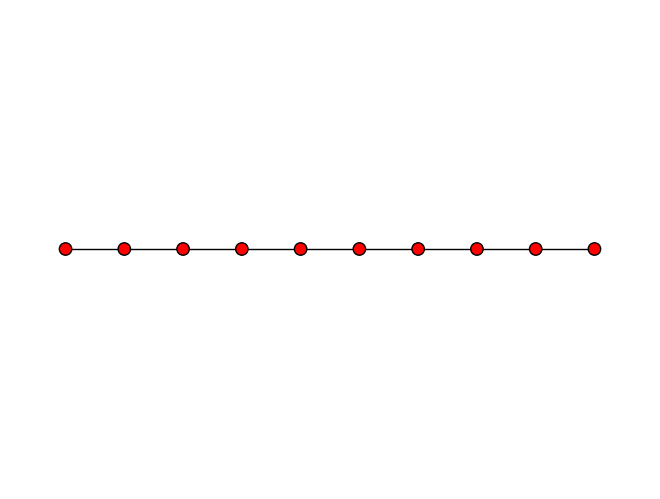

In [4]:
# create a line graph with 10 nodes and 9 edges
G = nx.Graph()

# create pos dictionary
pos = [(i,0) for i in range(10)]

# add edges
for n in range(9):
    G.add_edge(n,n+1)

# create the adjacency matrix
W = nx.adjacency_matrix(G).toarray()

# create a mapping for colors:
C = {0:'red', 1:'green'}
colors = list(C.keys())

# create adjacency matrix
W = nx.adjacency_matrix(G).toarray()

# create initial node states
X = np.zeros(len(G))

# draw the graph
draw_graph(G, X, C, pos)

0it [00:00, ?it/s]

1999it [00:01, 1200.21it/s]


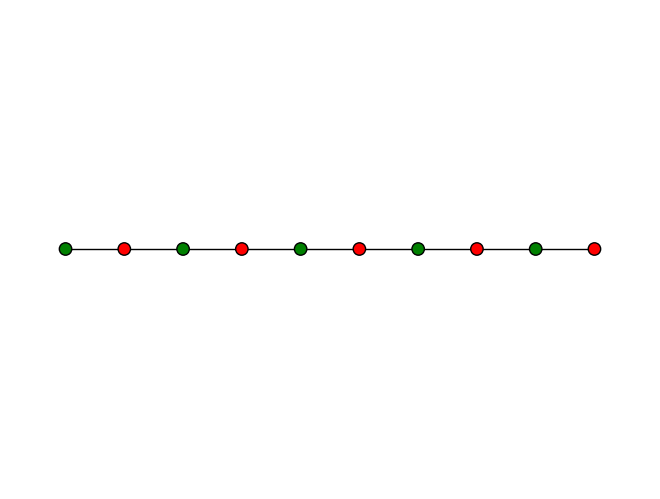

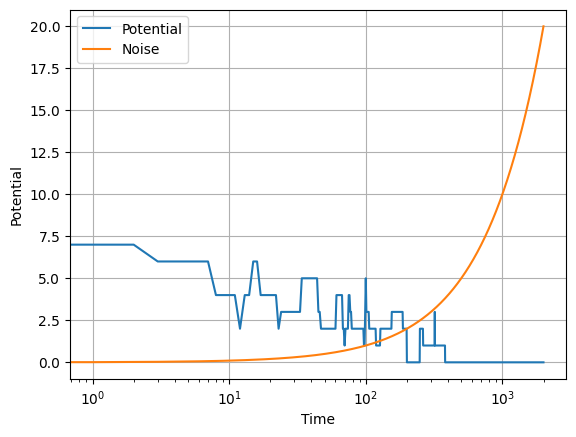

In [5]:
# consider the random walk in this way:
# at each discrete time step, one node is chosen uniformly at random
# and its color will be changed with probability described above

# compare function
cost = lambda c,X : c==X

# initial configuration
config = {
    'W': W,
    'X': np.zeros(len(G)),
    'iterations': 2000,
    'colors': list(C.keys()),
    'cost': cost,
    'noise': lambda t : t/100,
}

# run the dynamics
Xs = NBR_dynamics(**config)

# draw the final graph
draw_graph(G, Xs[-1], C, pos)

# calculate the potential
potentials = [NBR_potential(X, W, cost) for X in Xs]
assert potentials[0] == 9, 'Initial potential should be 9'

# draw the potential
draw_potential(potentials, config['noise'])
plt.show()

1999it [00:01, 1900.02it/s]00<?, ?it/s]
1999it [00:01, 1209.39it/s]01<01:46,  1.08s/it]
1999it [00:01, 1545.18it/s]02<02:19,  1.42s/it]
1999it [00:00, 2557.23it/s]04<02:13,  1.37s/it]
1999it [00:00, 2286.22it/s]04<01:49,  1.14s/it]
1999it [00:00, 3365.34it/s]05<01:39,  1.05s/it]
1999it [00:00, 3357.44it/s]06<01:24,  1.11it/s]
1999it [00:00, 3711.15it/s]06<01:14,  1.25it/s]
1999it [00:00, 2559.52it/s]07<01:06,  1.39it/s]
1999it [00:00, 2925.88it/s]08<01:07,  1.34it/s]
1999it [00:00, 3154.34it/s]:08<01:05,  1.37it/s]
1999it [00:00, 2735.80it/s]:09<01:02,  1.42it/s]
1999it [00:00, 2470.66it/s]:10<01:02,  1.40it/s]
1999it [00:01, 1755.94it/s]:11<01:04,  1.34it/s]
1999it [00:00, 2753.90it/s]:12<01:14,  1.15it/s]
1999it [00:00, 3050.93it/s]:13<01:10,  1.21it/s]
1999it [00:00, 3531.37it/s]:13<01:05,  1.28it/s]
1999it [00:00, 3482.05it/s]:14<00:59,  1.39it/s]
1999it [00:00, 2931.06it/s]:14<00:55,  1.48it/s]
1999it [00:00, 2977.45it/s]:15<00:55,  1.47it/s]
1999it [00:00, 3306.54it/s]:16<00:54, 

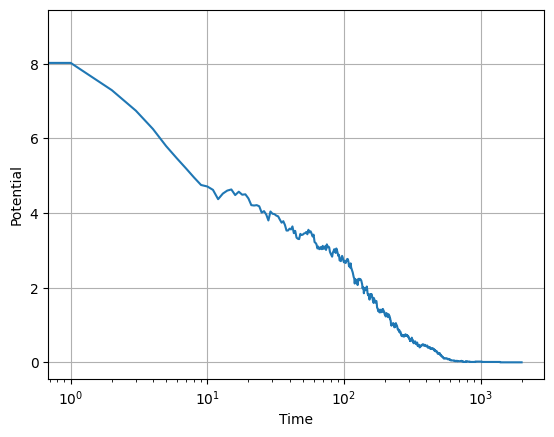

In [6]:
# use simulate function to run the dynamics n times
# and plot the average of the potential function

# create a np.arry from a generator
simulations = np.array(list(simulate(NBR_dynamics, config, 100)))

# calculate the potential for each simulation, applying NBR_potential to each row
potentials = np.apply_along_axis(NBR_potential, 2, simulations, W, cost)
potentials = potentials.mean(axis=0)
assert potentials[0] == 9, 'Initial potential should be 9'

# draw the potential
draw_potential(potentials)
plt.show()

## b) Assign wifi-channels to routers

Consider that now the cost function is different:
$$
c(x_i, x_j) = 
\begin{cases}
2 \texttt{ if } |x_i-x_j| = 0\\
1 \texttt{ if } |x_i-x_j| = 1\\
0 \texttt{ otherwise}
\end{cases}
$$

The probability distribution of the NBR dynamics, and the potential change accordingly.

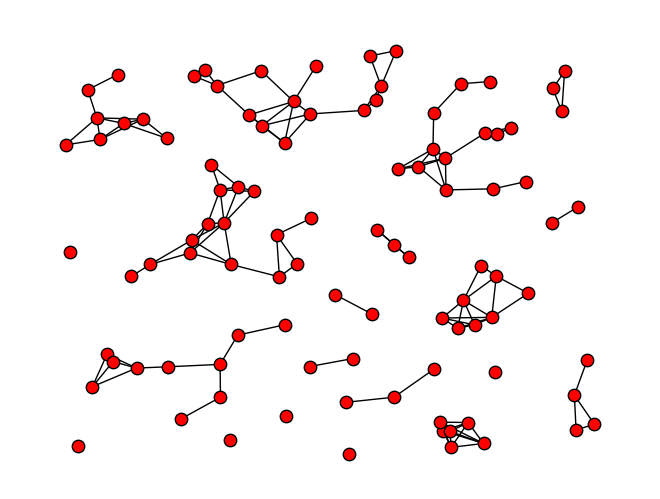

In [7]:
import scipy.io

# Load the .mat files
W = scipy.io.loadmat('data/wifi.mat')['wifi']
pos = scipy.io.loadmat('data/coords.mat')['coords']
# create routers, aka nodes
routers = np.arange(100)
# create colors
C = {
    1 : 'red',
    2 : 'green',
    3 : 'blue',
    4 : 'yellow',
    5 : 'magenta',
    6 : 'cyan',
    7 : 'white',
    8 : 'black',
}
# create a graph
G = nx.Graph(W)
# draw it
nx.draw(G, node_color='red', pos=pos, node_size=80, edgecolors='black')

13it [00:00, 126.10it/s]

1999it [00:09, 207.71it/s]


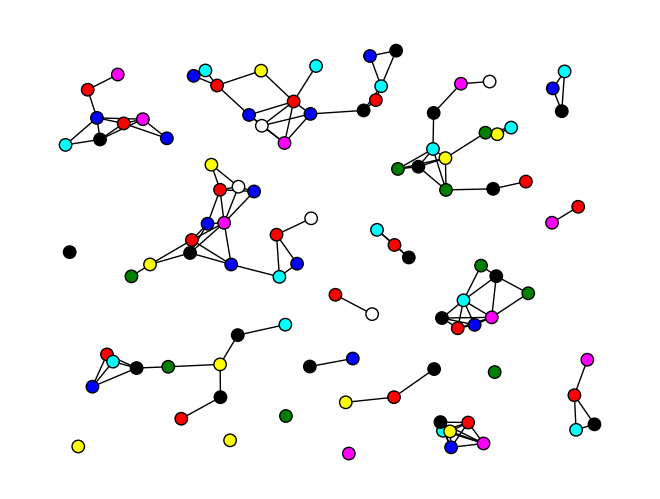

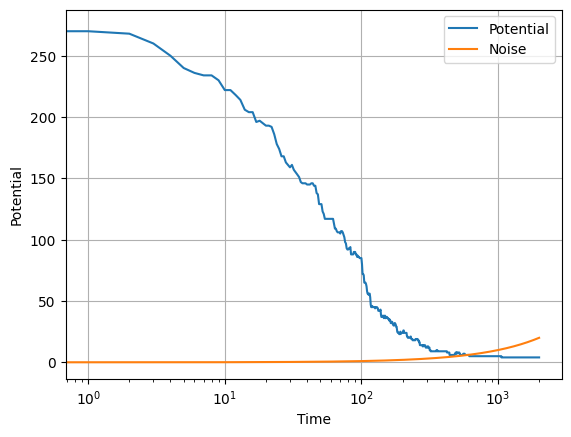

In [58]:
# create compare function
def cost(x, X):
    violations = np.zeros(len(X))
    diff = np.abs(x-X)
    violations[diff==0] = 2
    violations[diff==1] = 1
    return violations

# initial configuration
X = np.ones(len(G))

config = {
    'W' : W,
    'X' : X,
    'iterations' : 2000,
    'colors' : list(C.keys()),
    'cost' : cost,
    'noise' : lambda t : t/100,
}

# run the dynamics
Xs = NBR_dynamics(**config)

# draw the final graph
draw_graph(G, Xs[-1], C, pos)

# draw the potential
potentials = [NBR_potential(X, W, cost) for X in Xs]
draw_potential(potentials, config['noise'])

## c) Results of experimenting


### Lazy lazy numpy
We noticed that putting as **noise** numbers too big, the function `np.exp(-noise * ...)` round the result, which is very little, to 0.0.
The vector of probabilites computed in NBR_dynamics, as a consequence, ends up with `NaN` values.

An **easy solution** is to increment bytes for more precise computations. We are now trying with `np.float128(-noise * ...)` inside `np.exp( . )`, and casting back to `np.float64(probs)` after normalization.

Another **quick way** to handle 0.0 values: if the probabilities are all rounded to 0.0, and so normalizing them would end up with all `NaN` values, instead, we simply stop iterations, and return the result.

The **third and last** solution that we found is to compute the exponential using `mpmath`, set to 100 decimals. This library is far more precise than `numpy`.

We implemented the last one.


### Constant noises
After some expriment, we kept 4 values for constant noise: 0, 1, 100, 1000. We compared the results in the plot below: when incrementing the noise, the final result becomes more and more stable.

On the other hand, when considering $\eta=0$ and $t \rightarrow +\infty$, then $X(t)$ is a pure **random walk**.

1999it [00:02, 856.08it/s] 
1999it [00:02, 950.37it/s] 
1999it [00:01, 1185.90it/s]
1999it [00:01, 1257.08it/s]


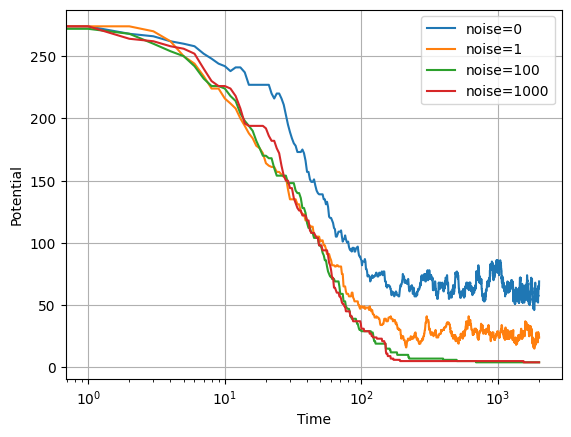

In [46]:
# draw various potentials, changing the noise
config = {
    'W' : W,
    'X' : np.ones(len(G)),
    'iterations' : 2000,
    'colors' : list(C.keys()),
    'cost' : cost,
}

# draw the potential for different noise values
#0, 1, 100, 1000, 
for noise in [0,1,100,1000]:
    config['noise'] = lambda t: noise
    Xs = NBR_dynamics(**config)
    potentials = [NBR_potential(X, W, cost) for X in Xs]
    plt.plot(potentials, label=f'noise={noise}')
plt.xscale('log')
plt.xlabel('Time')
plt.ylabel('Potential')
plt.legend()
plt.grid()
plt.show()

In [47]:
# with this function, you can check the final potential of each NBR_dynamics run
NBR_potential(Xs[-1], config['W'], config['cost'])

4.0

### Trying with different $\alpha : \eta(t)=\frac{t^\alpha}{100}$ 
We kept the **noise** of 100, and changed values of $\alpha$ from 1 to 20.

1999it [00:03, 562.28it/s]
1999it [00:01, 1181.04it/s]
1999it [00:01, 1022.02it/s]


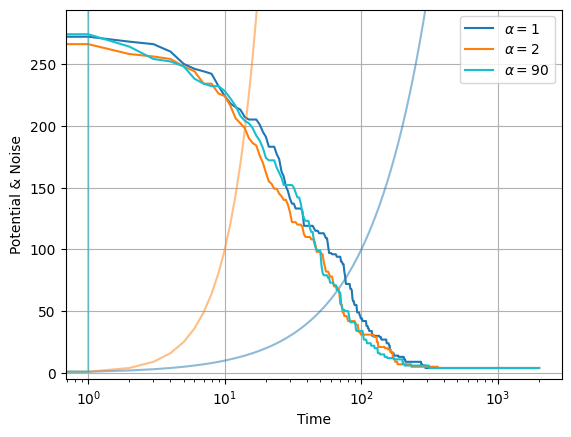

In [74]:
# set mpmath precision: number of decimal digits
mp.mp.dps = 100

# draw various potentials, changing the noise
config = {
    'W' : W,
    'X' : np.ones(len(G)),
    'iterations' : 2000,
    'colors' : list(C.keys()),
    'cost' : cost,
}
# different noise values
# 1,2,5,10, 50
for a in [1, 2, 90]:
    config['noise'] = lambda t: t**a
    Xs = NBR_dynamics(**config)
    potentials = [NBR_potential(X, W, cost) for X in Xs]
    plt.plot(potentials, label=f'$\\alpha={a}$', color='C'+str(a-1))
    plt.plot([config['noise'](t) for t in range(config['iterations'])], color='C'+str(a-1), alpha=0.5)
plt.xscale('log')
plt.xlabel('Time')
plt.ylabel('Potential & Noise')
plt.legend()
plt.grid()
plt.ylim(-5, max(potentials)+20)
plt.show()

In [33]:
# with this function, you can check the final potential of each NBR_dynamics run
NBR_potential(Xs[-1], config['W'], config['cost'])

4.0

### Different initial node states
We kept the original $\eta(t)=\frac{t}{100}$ and tried with different initializations, one for each color, and a random one.

1999it [00:04, 403.56it/s]
1999it [00:01, 1114.51it/s]
1999it [00:01, 1092.54it/s]
1999it [00:01, 1111.68it/s]
1999it [00:01, 1149.16it/s]
1999it [00:01, 1010.39it/s]
1999it [00:01, 1177.73it/s]
1999it [00:01, 1425.06it/s]
1999it [00:01, 1485.73it/s]


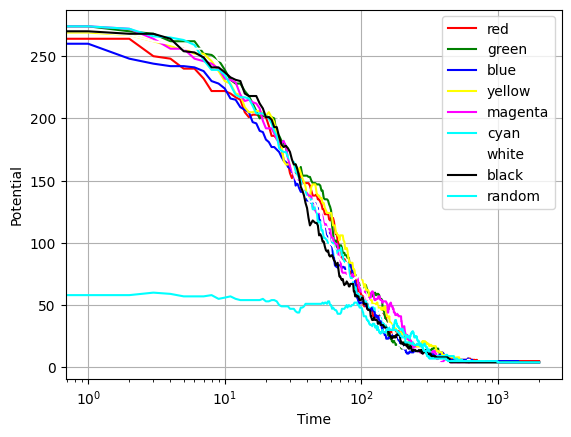

In [61]:
# draw various potentials, changing the initial condition
config = {
    'W' : W,
    'iterations' : 2000,
    'colors' : list(C.keys()),
    'cost' : cost,
    'noise' : lambda t : t/100,
}
ones = np.ones(len(G))# draw various potentials, changing the noise

# draw the potential for different noise values
config['noise'] = lambda t: t/100
for X in [ones*1, ones*2, ones*3, ones*4, ones*5, ones*6, ones*7, ones*8, np.random.randint(1,9,len(G))]:
    config['X'] = X
    Xs = NBR_dynamics(**config)
    potentials = [NBR_potential(X, W, cost) for X in Xs]
    color = C[X[0]] if isinstance(X[0], float) else "random"
    plt.plot(potentials, color=C[X[0]], label=color)
plt.xscale('log')
plt.xlabel('Time')
plt.ylabel('Potential')
plt.legend()
plt.grid()
plt.show()

In [59]:
# with this function, you can check the final potential of each NBR_dynamics run
NBR_potential(Xs[-1], config['W'], config['cost'])

4.0